Mammography DICOM data preprocessing examples

- Proper generation of TRAIN/VALID/TEST datasets
- Proper processing of DICOM data


VINDR dataset used as an example

In [1]:
import pandas as pd, numpy as np
import os, shutil
from glob import glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
sns.set(style='dark')

from pydicom import dcmread
from pydicom.dataset import FileDataset

<h2> Proper generation of TRAIN/VALID/TEST datasets </h2>

In [2]:
dataset_dir = 'C:/Users/JacekR/datasets/breast_density/vindr/raw'

In [3]:
def build_path(folder, file, parent=dataset_dir):
    return dataset_dir+"/"+folder+"/"+file+".dicom"

In [4]:
df = pd.read_csv(f'{dataset_dir}/breast-level_annotations.csv')
df['image_path'] = df.apply(lambda x: build_path(x.series_id, x.image_id), axis=1)
df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,image_path
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training,C:/Users/JacekR/datasets/breast_density/vindr/...
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training,C:/Users/JacekR/datasets/breast_density/vindr/...
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training,C:/Users/JacekR/datasets/breast_density/vindr/...
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training,C:/Users/JacekR/datasets/breast_density/vindr/...
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,C:/Users/JacekR/datasets/breast_density/vindr/...


In [5]:
df['image_path'][0]


'C:/Users/JacekR/datasets/breast_density/vindr/raw/b36517b9cbbcfd286a7ae04f643af97a/d8125545210c08e1b1793a5af6458ee2.dicom'

Please notice that:
- study_id/series_id - it is a DICOM based ID for a given patient's study or an image series. It should be used as a key to differentiate between TRAIN/TEST/VALID datasets. 
- image_id - it is a DICOM based ID for a given IMAGE. 

STUDY has a SERIES, SERIES has IMAGES.

For example:

For the study: b8d273e8601f348d3664778dae0e7e0b we have 4 records. Each has the same series_id but different image_id. In mammography, usually we have 4 images per series/study: 2 views for a Left breast (CC, MLO) and 2 views for the right breast (CC. MLO). BUT sometimes not all views per study are available. 
   
It is also theoretically popssible that there will be different series_id for the samne study_id. This is when each image is recorded as a seperate series. So it should be carefully analyzed when assigning an image to TRAIN/TEST/VALID datasets. It is better to use study_id as a unique id. But, different things could happed, so please be carefull. 

Read the additional CSV file to get information about classes (density OR finding). Use study_id/image_id to properly assign labels

In [6]:
df = pd.read_csv(f'{dataset_dir}/finding_annotations.csv')
# df['image_path'] = df.image_path.apply(lambda x: x.replace('CBIS-DDSM', dataset_dir))
df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training


<h2> Proper processing of DICOM data </h2>

It requires to:
A) process stored pixel data to a original values
B) use observation window to generate an image (pixel) to show on a display or store as a picture format (e.g. JPEG).

Ad. A).
Stored pixel values are typically integer values represented using 2 bytes per pixel. Using PyDicom read we can obtain 16-bits integers. But, in other DICOM attributes (stored in a file) information about data preprocessing could be stored to obtain the proper presentation cotext for data:
- intercept [0x0028, 0x1052], and slope  [0x0028, 0x1053] values could be stored to linearly transform stored pixel value to required presentation values, it. SLOPE * 16_BIT_PIXEL_VALUE + INTERCAPT
- VOI LUT () lookup table could be stored to use this table to map PIXEL VALUES to proper presentation values. In VOI LUT nonlinear transformation could be used (not very often). The related DICOM attributes are: ["(0028, 3000)", "(0028, 3002)", "(0028, 3003)", "(0028, 3004)", "(0028, 3006)"]

So:
1. Check if such attriobutes are defined
2. If so, apply proper transformation to input pixel data.

Ad. B).
Displays or picture file formats use (usually) 8-bits representation per component. In radiology we usually use one-component images (e.g. X-ray attenuation measurement). So input values could be 16bits, but display requires 8-bits for a grayscale image. The originally measure values correspond to tissues properties, so the radiologist can specify the range of values best, to observe tissues properites (e.g. other for bones, another for soft tissues). Therefore, the observation widnow is defined to cut input values to that window range, and then map the cutted input range to 8-bits to produce a grayscale image.

Example:
Range of pixel data: 0 - 2624
Window parameters set in a DICOM file, e.g. Window Center (or Level): 1640, Window Width: 1500
Result: Min: 1640-(1500/2)= 890   Max: 1640+(1500/2)



In [7]:
pixel_min = 0
pixel_max = 2624
wc = 1640
ww = 1500
window_min =  wc-(ww/2)
window_max =  wc+(ww/2)
print(f"Window min: {window_min}, Window max: {window_max}")

# y = ax + b
# 0 = a * window_min + b  -> b = - a * window_min
# 255 = a * window_max + b
# 255 =  a * window_max - a * window_min = a * (window_max-window_min) -> a = 255.0 / (window_max - window_min)


a = 255.0 / (window_max - window_min)
b = - a * window_min

print(f"Scaling factors slope: {a}, intercept: {b}")

scaled_min = int(a * window_min + b)
scaled_max = int(a * window_max + b)
# Use also round or other technique to get int value

print(f"Scaled values:  min: {scaled_min}, Window max: {scaled_max}")

# In PyDICOM we can use predefined properties to get WC/WW and functions to apply it to input data


Window min: 890.0, Window max: 2390.0
Scaling factors slope: 0.17, intercept: -151.3
Scaled values:  min: 0, Window max: 255


In [8]:
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut, apply_windowing

In [9]:
def process_presentation_context(dicom_path: str, debug=True):
    dicom_file = dcmread(dicom_path)
    dcm_pixel_array = dicom_file.pixel_array
    if debug:
        print(f"Min: {np.min(dcm_pixel_array)}, Max: {np.max(dcm_pixel_array)}") 
        wc = dicom_file.WindowCenter
        ww = dicom_file.WindowWidth
        print(f"WL: {wc}, WW: {ww}") 
        vmin = wc - ww/2
        vmax = wc + ww/2 
        print(f"New min: {vmin}, max: {vmax}") 
    img_data = apply_modality_lut(dcm_pixel_array, dicom_file)
    img_data = apply_windowing(img_data, dicom_file)
    return img_data.astype(np.uint16)
    

In [10]:
def show_dcm_image(dicom_path: str, title: str = "dcm img") -> None:
    img_data = process_presentation_context(dicom_path)
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.axis('off')
    #plt.imshow(dcm_pixel_array, cmap='gray', vmin=vmin, vmax=vmax)
    plt.imshow(img_data, cmap='gray')
    plt.show()

In [11]:
def show_images(dicom_path: str):
    
    img_data_presentation = process_presentation_context(dicom_path)
 
    dicom_file = dcmread(dicom_path)
    img_data_raw = dicom_file.pixel_array
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].imshow(img_data_raw, cmap='gray')
    axes[0].set_title("Image from RAW data")
    axes[1].imshow(img_data_presentation, cmap='gray')
    axes[1].set_title("Image using presentation context")
    fig.tight_layout()

Min: 0, Max: 2624
WL: 1640, WW: 1500
New min: 890.0, max: 2390.0


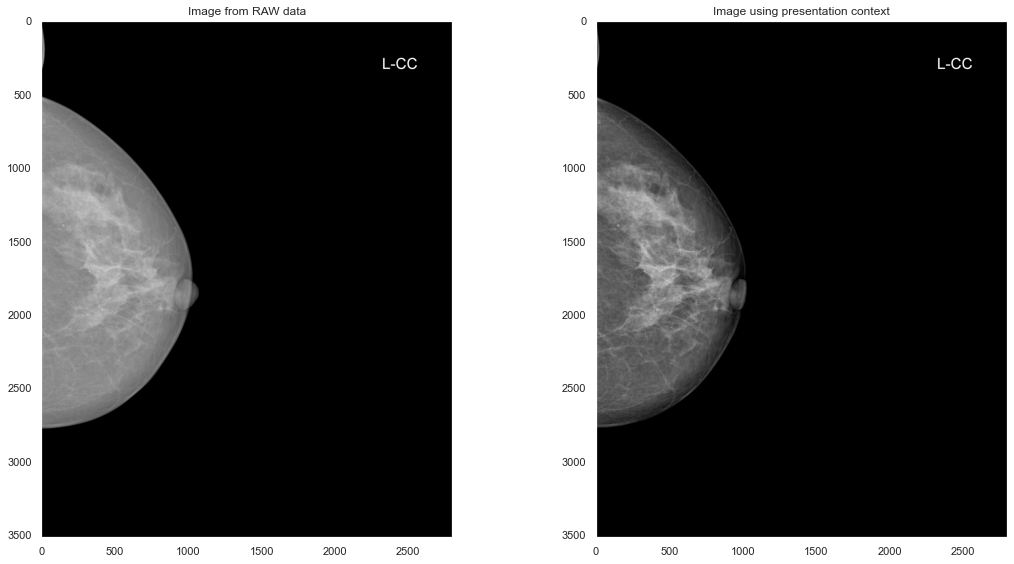

In [12]:
series_example = "00a369b4ec1e5e0ff34e6bd838e5f2d6"
image_example = "f3cbed97f4bb7897467e1e8bab45966e"
# show_dcm_image(df['image_path'][0])

dicom_file_to_read = build_path(series_example,image_example)
show_images(dicom_file_to_read)

Experimental functions to check if presentation attributes are set.

In [13]:
def check_rescale_factors(dicom_source):
    try:
        b_intercept = dicom_source[0x0028, 0x1052]
        if b_intercept is not None:
            print(b_intercept.value)
        else:
            print("1052 None")
            return False
    except:
        return False
    try:
        a_slope = dicom_source[0x0028, 0x1053]
        if a_slope is not None:
            print(a_slope.value)
        else:
            print("1053 None")
            return False
    except:
            return False
    # elem = dicom_source[0x0028, 0x1054]
    # if elem is not None:
    #     print(elem)
    # else:
    #     print("1054 None")
    if b_intercept.value == 0.0 and a_slope.value == 1.0:
        print("No change")
        return False
    
    return True
    
def check_voi_factors(dicom_source):
    #  lut_tags = ["(0028, 3000)", "(0028, 3002)", "(0028, 3003)", "(0028, 3004)", "(0028, 3006)"]
    
    try:
        elem = dicom_source[0x0028, 0x3000]
        if elem is not None:
            print(elem)
        else:
            print("0x3000 None")
    except:
        print("0x3000 None")
    try:
        elem = dicom_source[0x0028, 0x3002]
        if elem is not None:
            print(elem)
        else:
            print("0x3002 None")
    except:
        print("0x3002 None")
    try:
        elem = dicom_source[0x0028, 0x3004]
        if elem is not None:
            print(elem)
        else:
            print("0x3004 None")
    except:
        print("0x3004 None")
    elem = dicom_source[0x0028, 0x3002]
    if elem is not None:
        print(elem.value)
    else:
        print("0x3002 None")
   

In [14]:
data_source =  dcmread(dicom_file_to_read)
check_rescale_factors(data_source)

0
1
No change


False

In [15]:
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut, apply_windowing

# Use the function above to modify pixel data

<h2> Store data as 16-bits PNG images</h2>

Important to process input DICOM files and store pictures in the PNG formsat to use by different models.

In [16]:
from PIL import Image

In [17]:
# PILLOW allows to save data in different formats, e.g.:
# I;16 (16-bit unsigned integer pixels)
# I;16L (16-bit little endian unsigned integer pixels)
# I;16B (16-bit big endian unsigned integer pixels)
# See more at: https://pillow.readthedocs.io/en/stable/handbook/concepts.html

def save_16_bit_png_file(img_data, file_path, debug=False):
    array_buffer = img_data.tobytes()
    if debug:
        print(len(array_buffer))
        print(img_data.T.shape)
    img = Image.new("I", img_data.T.shape)
    img.frombytes(array_buffer, 'raw', "I;16")
    img.save(file_path)

In [18]:
series_example = "00a369b4ec1e5e0ff34e6bd838e5f2d6"
image_example = "f3cbed97f4bb7897467e1e8bab45966e"
# show_dcm_image(df['image_path'][0])

dicom_file_to_read = build_path(series_example,image_example)
img_data_presentation = process_presentation_context(dicom_file_to_read)
print(np.min(img_data_presentation), np.max(img_data_presentation))
print(img_data_presentation.dtype)

save_16_bit_png_file(img_data_presentation, "16_bit_dicom_example.png")

Min: 0, Max: 2624
WL: 1640, WW: 1500
New min: 890.0, max: 2390.0
0 4095
uint16


In [19]:
img_read = Image.open("16_bit_dicom_example.png")
print(img_read.mode)
print(img_read.palette)
print(img_read.format)
print(img_read.size)
arr = np.asarray(img_read)
print(f"Image min: {np.min(arr)}, max: {np.max(arr)}")

I
None
PNG
(2800, 3518)
Image min: 0, max: 4095


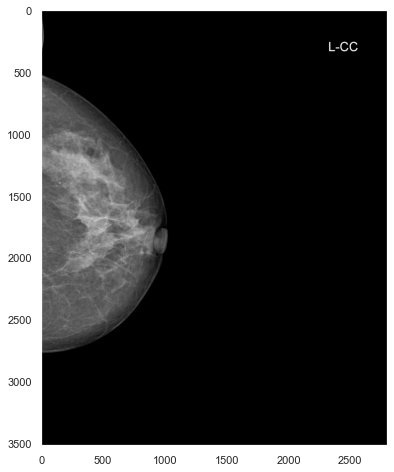

In [20]:
plt.figure(figsize=(8,8))
# plt.axis('off')
#plt.imshow(dcm_pixel_array, cmap='gray', vmin=vmin, vmax=vmax)
plt.imshow(arr, cmap='gray')
plt.show()

In [21]:
def generate_histogram(img, density=True, levels=256):
  
    hist = np.zeros([levels])

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            pixel = int(img[x, y])
            hist[pixel] += 1

    if density:
        hist /= (img.shape[0] * img.shape[1])
    return hist

(880, 700)
0.0006461038961038961 890 2390


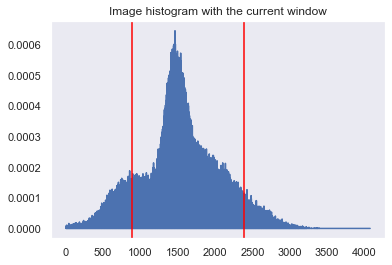

In [22]:
img_copy = arr.copy()
small_arr = img_copy[0::4, 0::4]
print(small_arr.shape)
hist = generate_histogram(small_arr, levels=(np.max(small_arr)+1))
clip = 10
plt.plot(hist[0+clip:len(hist)-clip])

wc = data_source.WindowCenter
ww = data_source.WindowWidth
window_min =  int(wc-(ww/2))
window_max =  int(wc+(ww/2))
print(np.max(hist[0+clip:len(hist)-clip]), window_min, window_max)

plt.axvline(x = window_min, color = 'red')
plt.axvline(x = window_max, color = 'red')
plt.title("Image histogram with the current window")
plt.show()

# plt.hist(gauss.ravel(), bins=(np.max(small_arr)+1), range=(0.0, 255.0), fc='k', ec='k')  # calculating histogram

In [23]:
# Ideas

# 1. to use in the future: starting with the default window, extend it to get XX% of data samples (to use more data)
# 2. to segment breast, then: a) set the backgroud to 0, b) extract best widnow for the breast object, c) (optionally) match histogram of breast object to Gauss

In [24]:
from breast_segment import segment
mask, bbox = segment(arr)

C:\Users\JacekR\AppData\Local\Temp/ipykernel_11140/191373704.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  mask, bbox = segment(arr)


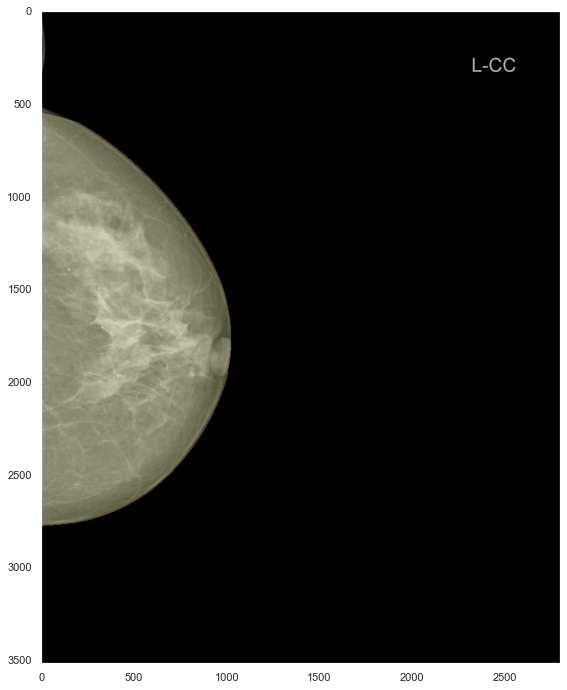

In [25]:
f = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
ax.imshow(arr, cmap='gray')
ax.imshow(mask, alpha=.3, cmap='inferno') # alpha controls the transparency
plt.show()